In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
df_titanic = sns.load_dataset('titanic')

In [6]:
df_titanic.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [7]:
df_titanic[df_titanic["embark_town"].isnull()]


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
61,1,1,female,38.0,0,0,80.0,NaN,First,woman,False,B,NaN,yes,True
829,1,1,female,62.0,0,0,80.0,NaN,First,woman,False,B,NaN,yes,True


In [8]:
df_titanic.dropna(axis=0,how='any',subset=['embark_town'],inplace=True)
df_titanic.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         0
class            0
who              0
adult_male       0
deck           688
embark_town      0
alive            0
alone            0
dtype: int64

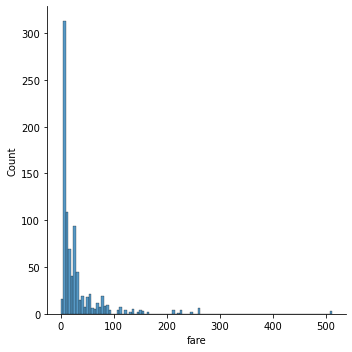

In [10]:
sns.displot(df_titanic['fare'])

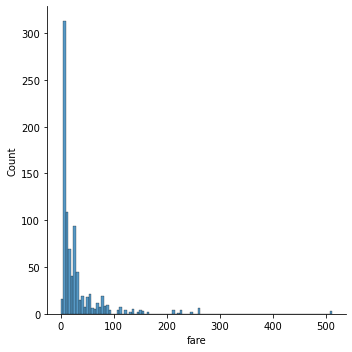

In [12]:
df_titanic['fare'].fillna(df_titanic['fare'].median(), inplace=True) 
sns.displot(df_titanic['fare'])

In [13]:
df_titanic['embarked'].isnull().sum()

0

In [ ]:
df_titanic['embarked'].fillna(df_titanic['embarked'].mode(), inplace=True)
df_titanic['embarked'].value_counts()

## 同类均值填充


In [14]:
df_titanic.groupby(['sex', 'pclass', 'who'])['age'].mean()

sex     pclass  who  
female  1       child    10.333333
                woman    35.137500
        2       child     6.600000
                woman    32.179688
        3       child     7.100000
                woman    27.854167
male    1       child     5.306667
                man      42.382653
        2       child     2.258889
                man      33.588889
        3       child     6.515000
                man      28.995556
Name: age, dtype: float64

In [15]:
age_group_mean = df_titanic.groupby(['sex', 'pclass', 'who'])['age'].mean().reset_index()
age_group_mean


,sex,pclass,who,age
0,female,1,child,10.333333
1,female,1,woman,35.137500
2,female,2,child,6.600000
3,female,2,woman,32.179688
4,female,3,child,7.100000
5,female,3,woman,27.854167
6,male,1,child,5.306667
7,male,1,man,42.382653
8,male,2,child,2.258889
9,male,2,man,33.588889


In [16]:
def select_group_age_median(row):
 condition = ((row['sex'] == age_group_mean['sex']) &
 (row['pclass'] == age_group_mean['pclass']) &
 (row['who'] == age_group_mean['who']))
 return age_group_mean[condition]['age'].values[0]

df_titanic['age'] =df_titanic.apply(lambda x: select_group_age_median(x) if np.isnan(x['age']) else x['age'],axis=1)

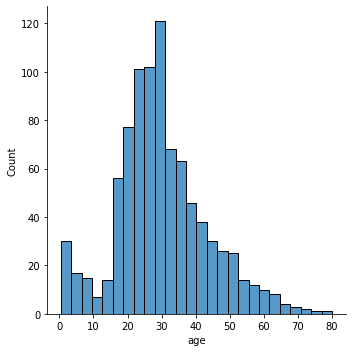

In [63]:
sns.displot(df_titanic['age'])

## 模型预测填充

In [35]:
df_titanic = sns.load_dataset('titanic')
df_titanic_age = df_titanic[['age', 'pclass', 'sex', 'who','fare', 'parch', 'sibsp']]
df_titanic_age = pd.get_dummies(df_titanic_age)
df_titanic_age.head()

,age,pclass,fare,parch,sibsp,sex_female,sex_male,who_child,who_man,who_woman
0,22.0,3,7.2500,0,1,0,1,0,1,0
1,38.0,1,71.2833,0,1,1,0,0,0,1
2,26.0,3,7.9250,0,0,1,0,0,0,1
3,35.0,1,53.1000,0,1,1,0,0,0,1
4,35.0,3,8.0500,0,0,0,1,0,1,0


In [36]:
# 乘客分成已知年龄和未知年龄两部分
known_age = df_titanic_age[df_titanic_age.age.notnull()]
unknown_age = df_titanic_age[df_titanic_age.age.isnull()]
# y 即目标年龄
y_for_age = known_age['age']
# X 即特征属性值
X_train_for_age = known_age.drop(['age'], axis=1)
X_test_for_age = unknown_age.drop(['age'], axis=1)

In [37]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
rfr.fit(X_train_for_age, y_for_age)

RandomForestRegressor(n_estimators=2000, n_jobs=-1, random_state=0)

In [38]:
X_test_for_age

,pclass,fare,parch,sibsp,sex_female,sex_male,who_child,who_man,who_woman
5,3,8.4583,0,0,0,1,0,1,0
17,2,13.0000,0,0,0,1,0,1,0
19,3,7.2250,0,0,1,0,0,0,1
26,3,7.2250,0,0,0,1,0,1,0
28,3,7.8792,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
859,3,7.2292,0,0,0,1,0,1,0
863,3,69.5500,2,8,1,0,0,0,1
868,3,9.5000,0,0,0,1,0,1,0
878,3,7.8958,0,0,0,1,0,1,0


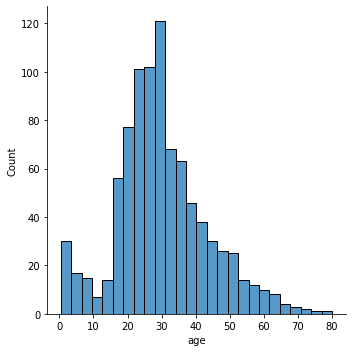

In [39]:
# 用得到的模型进行未知年龄结果预测
y_pred_age = rfr.predict(X_test_for_age)
# 用得到的预测结果填补原缺失数据
df_titanic.loc[df_titanic.age.isnull(), 'age'] = y_pred_age
sns.displot(df_titanic.age)

## 2.3 异常处理：
### 1) 异常值识别

    * 箱线法

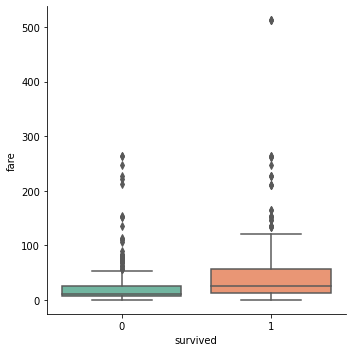

In [42]:
sns.catplot(y="fare",x="survived", kind="box", data=df_titanic,palette="Set2");

    * 正态分布

/home/wanzi/ml/cupoyMarathon/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

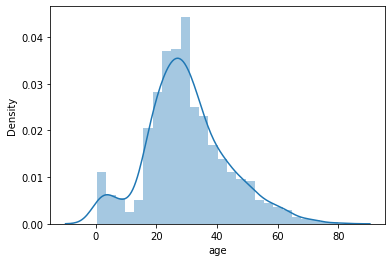

In [43]:
sns.distplot(df_titanic.age)

    * 异常值检测方法

<AxesSubplot:xlabel='fare', ylabel='age'>

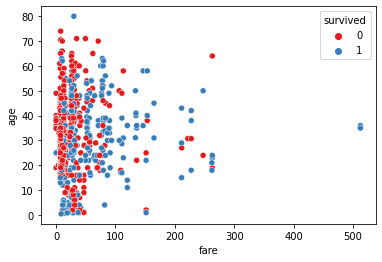

In [44]:
sns.scatterplot(x="fare", y="age", hue="survived",data=df_titanic,palette="Set1")

### 3.3.1 统计量构造 - 年龄分段：child、young、midlife、old

In [47]:
def age_bin(x):
 if x <= 18:
     return 'child'
 elif x <= 30:
     return 'young'
 elif x <= 55:
     return 'midlife'
 else:
     return 'old'
df_titanic['age_bin'] = df_titanic['age'].map(age_bin)
df_titanic['age_bin'].unique()

array(['young', 'midlife', 'child', 'old'], dtype=object)

### 3.3.1 统计量构造 - 抽取 title 特征

In [ ]:
df_titanic['title'] = df_titanic['name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
 
df_titanic['title'].value_counts()

### 3.3.1 统计量构造 - 抽取家庭规模

In [49]:
df_titanic['family_size'] = df_titanic['sibsp'] + df_titanic['parch'] + 1
df_titanic['family_size'].head()

0    2
1    2
2    1
3    2
4    1
Name: family_size, dtype: int64

### 3.4.1 过滤式 - 1) 方差过滤

In [51]:
from sklearn.feature_selection import VarianceThreshold
variancethreshold = VarianceThreshold() #实例化，默认方差为 0.方差<=0 的过滤掉
df_titanic_numerical = df_titanic[['age','sibsp','parch','fare','family_size']]
X_var = variancethreshold.fit_transform(df_titanic_numerical)    #获取删除不合格特征后的新特征矩阵
variancethreshold.variances_

array([ 79.58      ,   1.21467827,   0.64899903, 512.3292    ,
         2.60032675])

In [53]:
del_list = df_titanic_numerical.columns[variancethreshold.get_support()==0].to_list()  #获得删除
del_list

[]

### 3.3.3 数据分桶 - 数值变量分箱

In [54]:
df_titanic['fare_bin'], bins = pd.qcut(df_titanic['fare'], 5, retbins=True)
df_titanic['fare_bin'].value_counts()

(7.854, 10.5]        184
(21.679, 39.688]     180
(-0.001, 7.854]      179
(39.688, 512.329]    176
(10.5, 21.679]       172
Name: fare_bin, dtype: int64

In [55]:
bins

array([  0.    ,   7.8542,  10.5   ,  21.6792,  39.6875, 512.3292])

In [56]:
def fare_cut(age):
 if age <=  7.8958:
     return 0
 if age <= 10.5:
     return 1
 if age <= 21.6792:
     return 2
 if age <=  39.6875:
     return 3
 return 4

In [58]:
df_titanic['fare_bin'] = df_titanic['fare'].map(fare_cut)


In [59]:
# cut 等距离分箱
bins = [0, 12, 18, 65, 100]
pd.cut(df_titanic['age'], bins).value_counts

<bound method IndexOpsMixin.value_counts of 0      (18, 65]
1      (18, 65]
2      (18, 65]
3      (18, 65]
4      (18, 65]
         ...   
886    (18, 65]
887    (18, 65]
888    (18, 65]
889    (18, 65]
890    (18, 65]
Name: age, Length: 891, dtype: category
Categories (4, interval[int64, right]): [(0, 12] < (12, 18] < (18, 65] < (65, 100]]>